# Test de détection d'une bulle spéculative de Phillips, Wu et Yu (2011)

Instalation des packages

In [46]:
#install.packages("googledrive")
#install.packages("readxl")
#install.packages("ggplot2")
#install.packages("reshape")
#install.packages("urca")
#install.packages("exuber")
#install.packages("MultipleBubbles")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



On utilise la libraire exuber plus rapide que les autres librairies disponibles pour ce test.

## Réplication de PWY (2011) sur le NASDAQ

On réplique l'étude de Phillips, Wu et Yu, 2011, Explosive behavior in the 1990s Nasdaq: whend did exuberance escalate asset values?, International Economic Review, 52(1). PWY (2011) vérifient l'existence d'une bulle spéculative sur le [NASDAQ](https://www.investopedia.com/terms/n/nasdaqcompositeindex.asp) qui est l'indice des valeurs technologiques.

Les auteurs collectent trois séries sur Datastream :

1. les valeurs de l'indice Nasdaq Composite
2. Le NASDAQ composite dividend yield, qui correspond au ratio dividend/prix
3. l'indice des prix à la consommation

Les données sont mensuelles à partir de juillet 1973 jusqu'à juin 2023 (600 observations). Les données des auteurs couvraient la période février 1973 à juin 2005.

In [2]:
library(googledrive)

In [4]:
drive_download("https://docs.google.com/spreadsheets/d/1ytyYqLvjJS6pJE0u13lshWcZ5eUCJaez/edit?usp=share_link&ouid=116043692381646876229&rtpof=true&sd=true")

File downloaded:

• wheat_futures.xlsx <id: 1ytyYqLvjJS6pJE0u13lshWcZ5eUCJaez>

Saved locally as:

• wheat_futures.xlsx



In [5]:
drive_download("https://docs.google.com/spreadsheets/d/1_V-5BnT37q8Azv5XvNv4mflMQoKGyBt0/edit?usp=share_link&ouid=116043692381646876229&rtpof=true&sd=true")

File downloaded:

• data_nasdaq.xlsx <id: 1_V-5BnT37q8Azv5XvNv4mflMQoKGyBt0>

Saved locally as:

• data_nasdaq.xlsx



In [9]:
library(readxl)
nasdaq<-read_xlsx(path = "data_nasdaq.xlsx",skip=3,sheet = c("nasdaq"))
colnames(nasdaq)<-c("date","DY","P")
cpi<-read_xlsx(path = "data_nasdaq.xlsx",skip=3,sheet = c("cpi"))
colnames(cpi)<-c("date","cpi")

Les auteurs effectuent les calculs suivants :

1.    Calcul de la série des dividendes = prix $\times$ dividend yield
2.    Division par l'indice des prix à la consommation pour se ramener en valeur réelle
3.    Normalisation à 100 de la première observation (juillet 1973) pour l'indice et le dividende.

In [10]:
nasdaq$D<-nasdaq$P*nasdaq$DY
nasdaq$rP<-nasdaq$P/cpi$cpi
nasdaq$rD<-nasdaq$D/cpi$cpi
nasdaq$nrP<-100*nasdaq$rP/nasdaq$rP[1]
nasdaq$nrD<-100*nasdaq$rD/nasdaq$rD[1]
df<-data.frame(nasdaq[c("date","nrP","nrD")])

On représente les observations sur la totalité de la période.

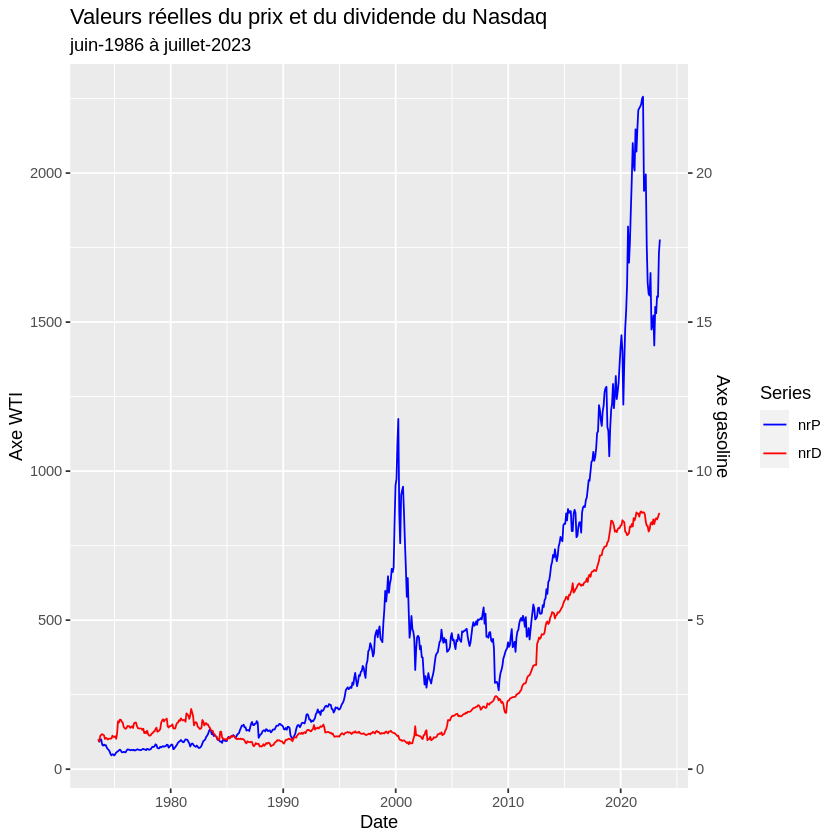

In [12]:
library(ggplot2)
library(reshape)
df_F<-df
data_plot<-df_F
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=date,y=value,color=variable))+
  scale_y_continuous(
    name="Axe WTI",
    sec.axis = sec_axis(~.*0.01,name="Axe gasoline")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Valeurs réelles du prix et du dividende du Nasdaq",subtitle = "juin-1986 à juillet-2023")

### Etude sur la période juillet 1973 à juin 2005




PWY vérifient l'existence d'une bulle spéculative sur la période 1973-2005, qui comprend la bulle internet des années 1990 (leur échantillon commence en février 1973 mais nous n'avons pas ces observations)






In [13]:
df_PWY<-df[df$date<="2005-06-30",]

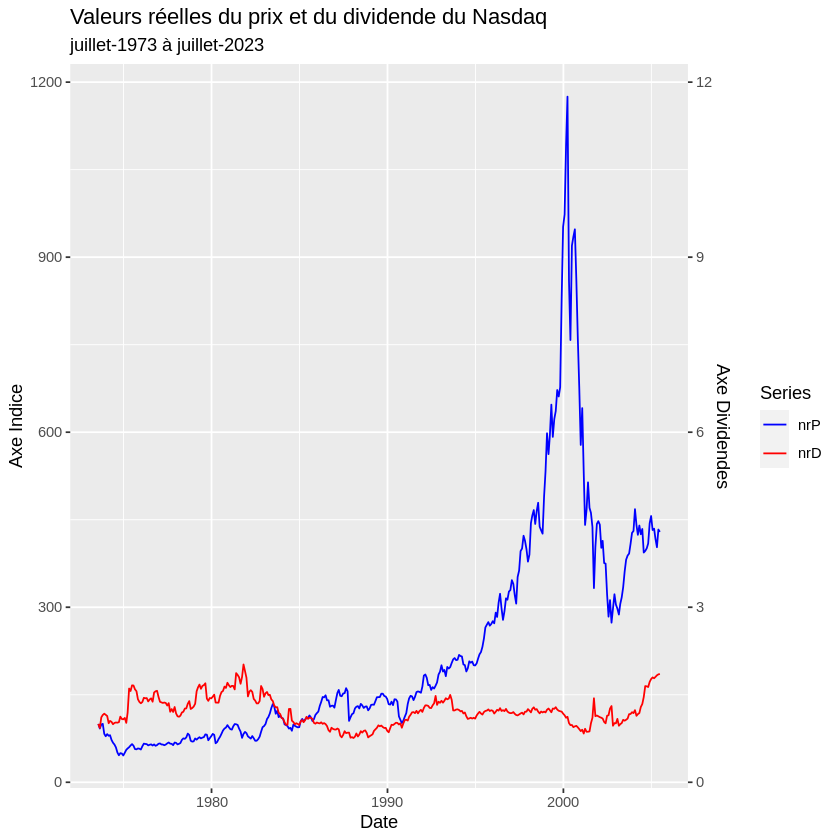

In [14]:
library(ggplot2)
library(reshape)
data_plot<-df_PWY
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=date,y=value,color=variable))+
  scale_y_continuous(
    name="Axe Indice",
    sec.axis = sec_axis(~.*0.01,name="Axe Dividendes")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Valeurs réelles du prix et du dividende du Nasdaq",subtitle = "juillet-1973 à juillet-2023")

Le graphique montre qu'à partir du milieu des années 1990 on observe une déconnexion entre l'évolution de l'indice qui croit de manière explosive jusque 2000, et celle des dividendes qui reste stable.  L'évolution de l'indice n'est pas expliquée par celle des dividendes ce qui est interprété comme le signe d'une bulle spéculative.

On va donc appliquer le test de détection de PWY(2011) aux deux séries.

#### Tests de détection d'une bulle spéculative

On estime la régression ADF :
$$
x_{t} = \mu_{x} + \rho x_{t-1} + \sum_{j=1}^{p} \phi_{j} \Delta x_{t-j} + \epsilon_{x,t}
$$
avec $\epsilon_{x,t} \sim NID(0,\sigma^{2}_{x})$.

On teste l'hypothèse nulle de racine unitaire contre l'hypothèse alternative d'une racine explosive. On a donc un test unilatéral du coté droit.

$$
\left\lbrace
\begin{array}{l}
H_{0} : \rho =1 \Rightarrow \,racine\,unitaire\\
H_{1} : \rho>1\, \Rightarrow \,racine\,explosive
\end{array}
\right.
$$

en faisant des régressions forward sur des fractions $r_{0} \leq r\leq 1$ des observations, on obtient la statistique

$$SADF(r_{0})=\sup_{r \in [r_{0},1]} ADF_{r}$$ où $ADF = \frac{\hat{\rho}-1}{\hat{\sigma}_{\hat{\rho}}}$

#### Test d'une bulle sur les dividendes


PWY(2011) appliquent les tests sur les séries en log.

Pour faire le test, on doit :

1. indiquer la taille de la fenêtre d'estimation initiale (la fraction $r_{0}$). On laisse la spécification par défaut qui préconise que une fenêtre égale à $(0.01+1.8/\sqrt(T))T$ où $T$ est le nombre d'observations.


2. Le nombre de retards dans la régression ADF. Il est préconisé de prendre un nombre de retards égal à 0 ou 1 pour éviter des décisions érronées (risque d'une erreur de première espèce mal contrôlée)

In [16]:
library(urca)
adf1<-ur.df(y = log(df_PWY$nrD),type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.297079 -0.026197  0.001288  0.025300  0.297497 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.165964   0.070977   2.338   0.0199 *
z.lag.1     -0.034353   0.014825  -2.317   0.0210 *
z.diff.lag  -0.001824   0.052420  -0.035   0.9723  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05696 on 368 degrees of freedom
Multiple R-squared:  0.01483,	Adjusted R-squared:  0.009476 
F-statistic:  2.77 on 2 and 368 DF,  p-value: 0.06398


Value of test-statistic is: -2.3172 2.8377 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


Le critère AIC préconise 1 retard pour la régression ADF, ce qui est compatible avec les valeurs préconisées pour le test SADF. On peut remarquer que ce retard n'est pas singificativement différent de 0. (les résultats demeurent inchangés avec 0 retard).

In [18]:
library(exuber)
x<-log(df_PWY$nrD)
psy_minw(x) # taille conseillée de la fenetre d'estimation initiale
sprintf("La taille conseillée de la fenetre d'estimation initiale %f",psy_minw(x))
radf_D_PWY <-radf(x,lag=1) # utilise psy_minw(x) comme valeur par défaut
sprintf("La statistique du test SADF est %f",radf_D_PWY$sadf)

[1] 39

[1] "La taille conseillée de la fenetre d'estimation initiale 39.000000"

[1] "La statistique du test SADF est -1.574939"

Pour des échantillons de moins de 600 observations, les seuils critiques sont stockés dans radf_crit. Les seuils critiques dépendent du nombre d'observations de la fenêtre d'estimation initiale. Dans notre cas, la taille de cette fenêtre est égale à 39.

In [19]:
radf_crit$n39$sadf_cv

90%       95%       99% 
0.8284761 1.1616426 1.8763872

La statistique du test $SADF = -1.574$ est inférieure aux trois seuils de rejet. On ne peut pas rejeter l'hypothèse nulle de racine unitaire contre celle d'une dynamique explosive.

In [20]:
diagnostics(radf_D_PWY,option = "sadf")

Using `radf_crit` for `cv`.



── Diagnostics (option = sadf) ────────────────────────────────── Monte Carlo ──

series1:  Cannot reject H0

On ne  peut pas rejeter l'hypothèse nulle de racine unitaire. On conclut qui'l n'y a pas eu d'épisode de dynamique explosive sur les dividendes.

#### Test d'une bulle sur l'indice Nasdaq

In [21]:
library(urca)
adf2<-ur.df(y = log(df_PWY$nrP),type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf2)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38995 -0.03428  0.00856  0.03871  0.22034 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.028494   0.023928   1.191   0.2345  
z.lag.1     -0.004569   0.004622  -0.989   0.3236  
z.diff.lag1  0.127924   0.051875   2.466   0.0141 *
z.diff.lag2 -0.086767   0.051927  -1.671   0.0956 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0671 on 367 degrees of freedom
Multiple R-squared:  0.02385,	Adjusted R-squared:  0.01587 
F-statistic: 2.989 on 3 and 367 DF,  p-value: 0.03106


Value of test-statistic is: -0.9885 1.5478 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79

Le critère AIC recommande 2 retards.

In [22]:
library(exuber)
x<-log(df_PWY$nrP)
radf_P_PWY <-radf(x,lag=2)
sprintf("La statistique du test SADF est %f",radf_P_PWY$sadf)

[1] "La statistique du test SADF est 2.042660"

In [23]:
radf_crit$n39$sadf_cv

90%       95%       99% 
0.8284761 1.1616426 1.8763872

La statistique du test $SADF = 2.042$ est supérieur aux trois seuils de rejet. On rejette l'hypothèse nulle de racine unitaire contre celle d'une dynamique explosive pour un risque de première espèce de 1%.

In [ ]:
diagnostics(radf_P_PWY,option = "sadf")

Dès que l'on rejete l'hypothèse nulle de racine unitaire en faveur de l'hypothèse alternative d'une dynamique explosive, on peut déterminer les dates initiale et finale de la bulle.

On peut fixer la durée mininale d'une bulle, de manière à éviter de sélectionner des périodes trop courtes pas interprétable. La spécification par défaut utilise la fonction psy_ds()

In [24]:
sprintf("La longueur minimale d'une bulle est %f",psy_ds(x))
date_bulle<-datestamp(radf_P_PWY,min_duration = psy_ds(x),option = "sadf")
date_bulle

[1] "La longueur minimale d'une bulle est 6.000000"

Using `radf_crit` for `cv`.



Start,Peak,End,Duration,Signal,Ongoing
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
287,321,333,46,positive,FALSE


In [25]:
df_PWY$date[date_bulle$series1$Start[1]]
df_PWY$date[date_bulle$series1$Peak[1]]
df_PWY$date[date_bulle$series1$End[1]]

[1] "1997-05-26 UTC"

[1] "2000-03-26 UTC"

[1] "2001-03-26 UTC"

La bulle est détectée à partir de mai 1997, elle atteint son pic en mars 2000 et se termine en mars 2001. Sa durée est de 46 mois. (A noter : PWY(2011) ne trouvent pas la même date de début de la bulle.)

Using `radf_crit` for `cv`.



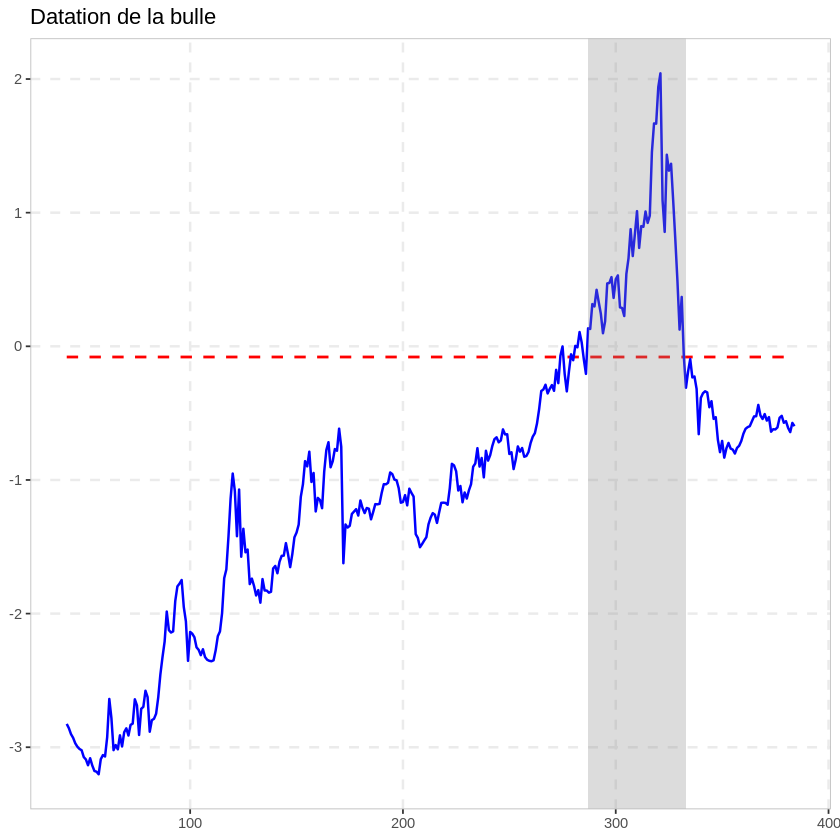

In [26]:
p<-autoplot(radf_P_PWY,option = "sadf",min_duration = psy_ds(x))
p+ggtitle("Datation de la bulle")

#### Calcul des seuils critiques



On peut aussi recalculer des seuils critiques pour chaque série par des simulations de Monte-Carlo. On prend en compte le nombre d'observations ce qui n'était pas le cas avant

In [27]:
x<-log(df_PWY$nrP)
mc_critical_values <- radf_mc_cv(n=length(x), nrep=1000,seed = 145)
summary(radf_P_PWY,mc_critical_values)

stat,tstat,90,95,99
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
adf,-0.5975417,-1.120670,-1.007044,-0.9161431
sadf,2.0426604,0.542979,0.643308,0.7235712
gsadf,2.3110183,1.786552,1.831023,1.8665993


On utilise les seuils critiques obtenus par simulation pour faire le test.

In [28]:
diagnostics(radf_P_PWY,mc_critical_values,option = "sadf")

── Diagnostics (option = sadf) ────────────────────────────────── Monte Carlo ──

series1:  Rejects H0 at the 1% significance level

#### Datation de la bulle spéculative

In [29]:
date_bulle<-datestamp(radf_P_PWY,cv=mc_critical_values,min_duration = psy_ds(x),option = "sadf")
date_bulle

Start,Peak,End,Duration,Signal,Ongoing
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
287,321,333,46,positive,FALSE


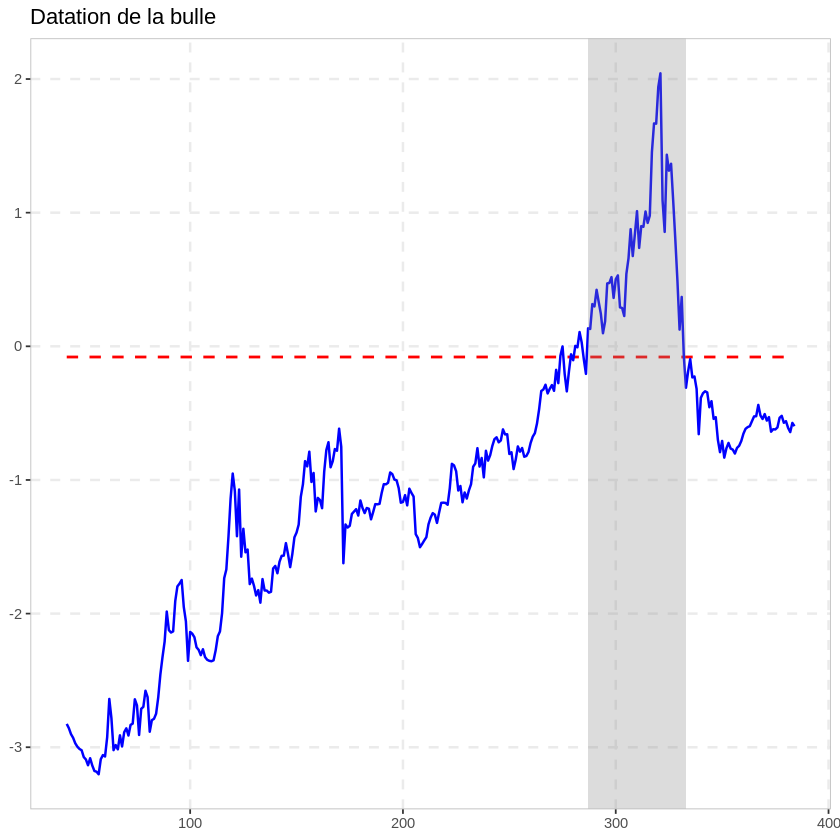

In [30]:
autoplot_x_sadf<-autoplot(radf_P_PWY,option="sadf",cv=mc_critical_values,min_duration = psy_ds(x))+labs(title="Datation de la bulle")
autoplot_x_sadf

### Etude sur la période à partir de 2002

In [31]:
df_PWY_T2<-df[df$date>="2002-01-01",]

#### Représentation graphique de l'indice et des dividendes

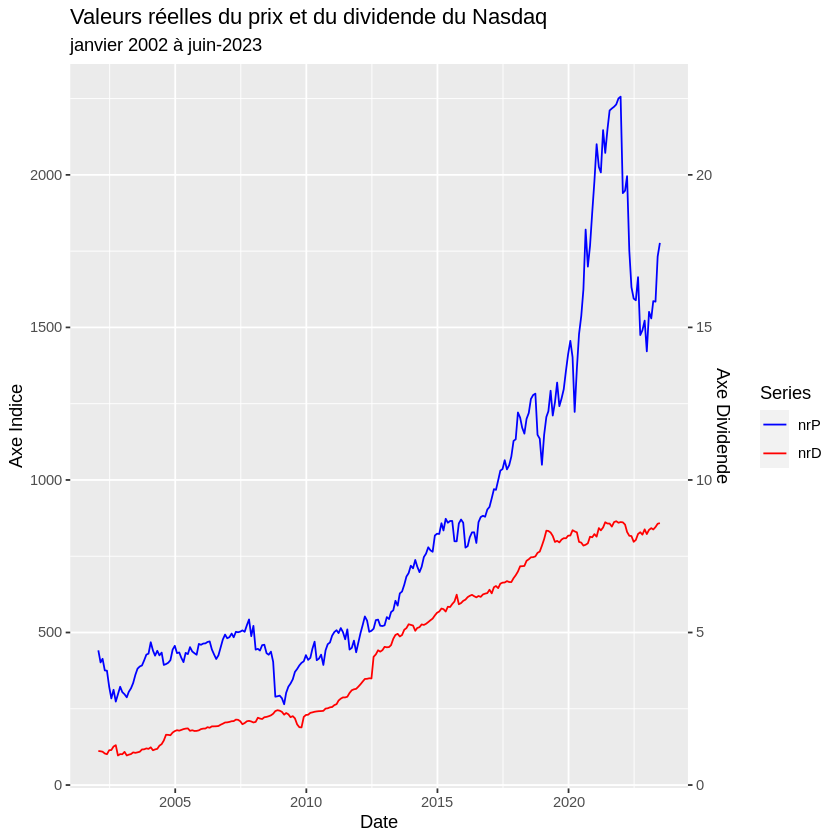

In [32]:
library(ggplot2)
library(reshape)
data_plot<-df_PWY_T2
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=date,y=value,color=variable))+
  scale_y_continuous(
    name="Axe Indice",
    sec.axis = sec_axis(~.*0.01,name="Axe Dividende")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Valeurs réelles du prix et du dividende du Nasdaq",subtitle = "janvier 2002 à juin-2023")

#### Test d'une bulle sur les dividendes

In [33]:
library(urca)
adf1<-ur.df(y = log(df_PWY_T2$nrD),type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.103778 -0.011373 -0.001007  0.011306  0.172768 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.037493   0.015971   2.348   0.0197 *  
z.lag.1     -0.005176   0.002640  -1.961   0.0511 .  
z.diff.lag1  0.112096   0.062143   1.804   0.0725 .  
z.diff.lag2  0.038009   0.061250   0.621   0.5355    
z.diff.lag3 -0.134116   0.060881  -2.203   0.0286 *  
z.diff.lag4  0.210785   0.050690   4.158 4.47e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02682 on 239 degrees of freedom
Multiple R-squared:  0.1047,	Adjusted R-squared:  0.08601 
F-statistic: 5.592 on 5 and 239 DF,  p-value: 6.799e-05


Value of test-statist

In [34]:
library(exuber)
x<-log(df_PWY_T2$nrD)
radf_D_F <-radf(x,lag=4)
sprintf("La statistique du test SADF est %f",radf_D_F$sadf)
diagnostics(radf_D_F,option = "sadf")

[1] "La statistique du test SADF est 0.506616"

Using `radf_crit` for `cv`.



── Diagnostics (option = sadf) ────────────────────────────────── Monte Carlo ──

series1:  Cannot reject H0

On ne rejette pas l'hypothèse nulle de racine unitaire pour les dividendes

In [35]:
library(urca)
adf1<-ur.df(y = log(df_PWY_T2$nrP),type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.34405 -0.02064  0.00361  0.03285  0.11963 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.032773   0.040421   0.811    0.418
z.lag.1     -0.003860   0.006143  -0.628    0.530
z.diff.lag  -0.022426   0.064281  -0.349    0.727

Residual standard error: 0.05399 on 242 degrees of freedom
Multiple R-squared:  0.002236,	Adjusted R-squared:  -0.00601 
F-statistic: 0.2712 on 2 and 242 DF,  p-value: 0.7627


Value of test-statistic is: -0.6283 2.5011 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


In [36]:
library(exuber)
x<-log(df_PWY_T2$nrP)
radf_P_F <-radf(x,lag=1)
sprintf("La statistique du test SADF est %f",radf_P_F$sadf)
diagnostics(radf_P_F,option = "sadf")

[1] "La statistique du test SADF est 0.936033"

Using `radf_crit` for `cv`.



── Diagnostics (option = sadf) ────────────────────────────────── Monte Carlo ──

series1:  Cannot reject H0

On ne rejette pas non plus l'hypothèse nulle de racine unitaire pour l'indice sur la seconde partie de l'échantillon.
On n'a pas les preuves statistiques d'une bulle spéculative malgré le comportement de l'indice en 2020 et 2015.

In [37]:
x<-log(df_PWY_T2$nrP)
mc_critical_values <- radf_mc_cv(n=length(x), nrep=1000,seed = 145)
summary(radf_P_F,mc_critical_values)
diagnostics(radf_P_F,mc_critical_values)

stat,tstat,90,95,99
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
adf,-0.1239018,-1.2030902,-1.0034184,-0.8436810
sadf,0.9360333,0.7703894,0.8907751,0.9870836
gsadf,1.1086423,1.1956541,1.4861620,1.7185684


── Diagnostics (option = gsadf) ───────────────────────────────── Monte Carlo ──

series1:  Cannot reject H0

On ne détecte pas non plus de bulle avec les valeurs critiques calculées par des simulation de Monte-Carlo

## Test de détection de bulles spéculatives sur le prix du  blé

Etienne, X. L., Irwin, S. H., & Garcia, P. (2014). Bubbles in food commodity markets: Four decades of evidence. Journal of International Money and Finance, 42, 129-155. applique le test de PWY (2011) à la détection de bulles spéculatives sur les marchés des matières premières. Ils utilisent les prix des contrat futures, c'est-à-dire des prix à terme déterminés sur les marchés à terme. On va appiquer le test au prix du blé entre 2000.  On ne dispose que du prix futures et pas de série représentant la valeur fondamentale du blé.

In [38]:
library(readxl)
wheat<-read_xlsx(path = "wheat_futures.xlsx",skip=3,sheet = c("M"))
colnames(wheat)<-c("date","P")
df_wheat_res<-wheat[wheat$date>="2000-01-01" & wheat$date<"2015-01-01",]

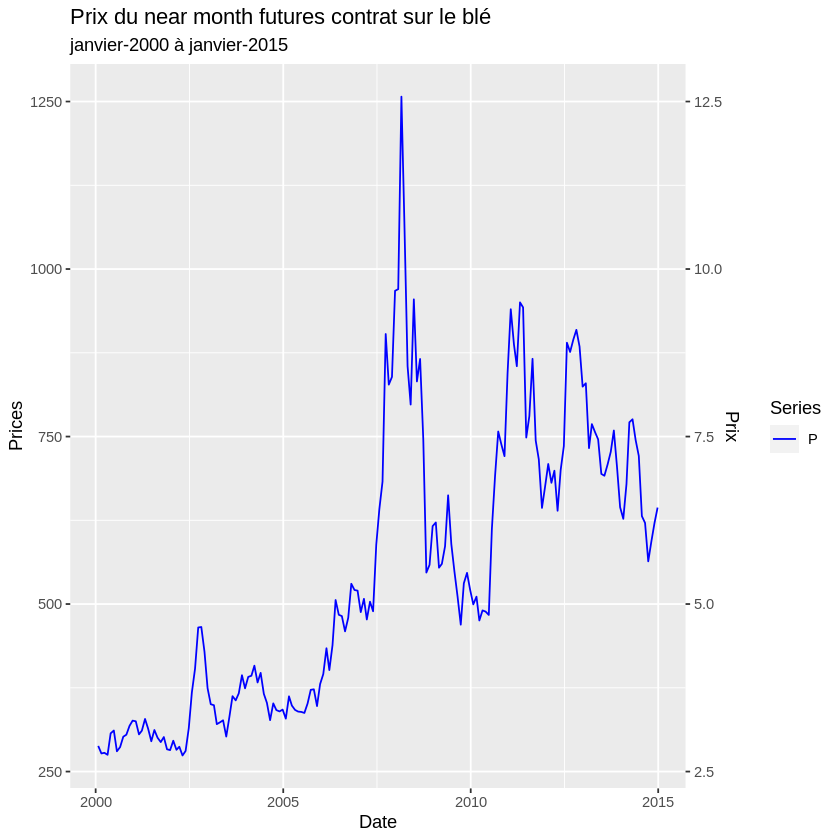

In [40]:
library(ggplot2)
library(reshape)
data_plot<-df_wheat_res
data_melt=melt(as.data.frame(data_plot),id.vars = 1)

p_us<-ggplot(data=data_melt,aes(x=Date))+geom_line(aes(x=date,y=value,color=variable))+
  scale_y_continuous(
    name="Prices",
    sec.axis = sec_axis(~.*0.01,name="Prix")
    )+ scale_color_manual(values = c('blue',"red"))+ labs(color = 'Series')
p_us+labs(y="prix",title = "Prix du near month futures contrat sur le blé",subtitle = "janvier-2000 à janvier-2015")

In [41]:
library(urca)
adf1<-ur.df(y = log(df_wheat_res$P),type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.291180 -0.061754 -0.005047  0.049318  0.279738 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.20497    0.11210   1.828   0.0693 .
z.lag.1     -0.03214    0.01788  -1.797   0.0741 .
z.diff.lag   0.07461    0.07759   0.962   0.3377  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08686 on 164 degrees of freedom
Multiple R-squared:  0.02296,	Adjusted R-squared:  0.01104 
F-statistic: 1.927 on 2 and 164 DF,  p-value: 0.1489


Value of test-statistic is: -1.7972 1.7796 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.46 -2.88 -2.57
phi1  6.52  4.63  3.81


In [42]:
library(exuber)
x<-log(df_wheat_res$P)
#mc_critical_values <- radf_mc_cv(n=length(x), nrep=1000,seed = 145)

radf_WP <-radf(x,lag=1)
sprintf("La statistique du test SADF est %f",radf_WP$sadf)
diagnostics(radf_WP,option = "sadf",)

[1] "La statistique du test SADF est 1.890147"

Using `radf_crit` for `cv`.



── Diagnostics (option = sadf) ────────────────────────────────── Monte Carlo ──

series1:  Rejects H0 at the 5% significance level

In [43]:
date_bulle<-datestamp(radf_WP,option = "sadf",min_duration = psy_ds(x))
date_bulle

Using `radf_crit` for `cv`.



Start,Peak,End,Duration,Signal,Ongoing
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
93,98,100,7,positive,FALSE


Using `radf_crit` for `cv`.



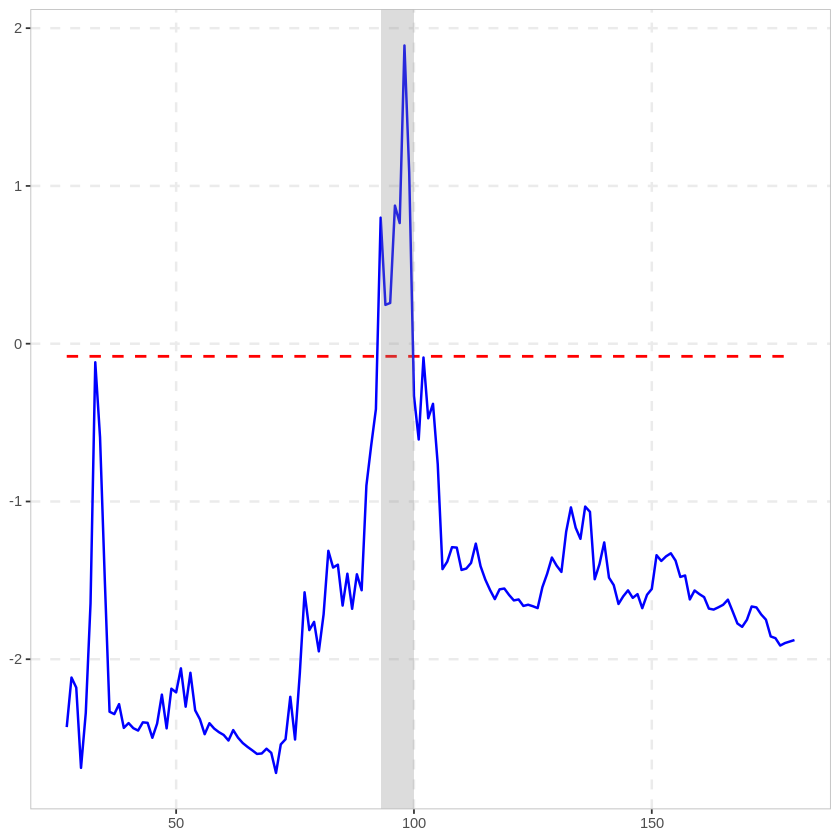

In [44]:
autoplot(radf_WP,option="sadf",min_duration = psy_ds(x))+labs(title=NULL)

In [45]:
df_wheat_res$date[date_bulle$series1$Start[1]]
df_wheat_res$date[date_bulle$series1$Peak[1]]
df_wheat_res$date[date_bulle$series1$End[1]]

[1] "2007-09-26 UTC"

[1] "2008-02-26 UTC"

[1] "2008-04-26 UTC"

On détecte la présence d'une bulle spéculative d'une durée de 7 mois entre septembre 2007 et mai 2008.

## Données SP Price dividend ratio



Robert Shiller [website](http://www.econ.yale.edu/~shiller/data.htm)

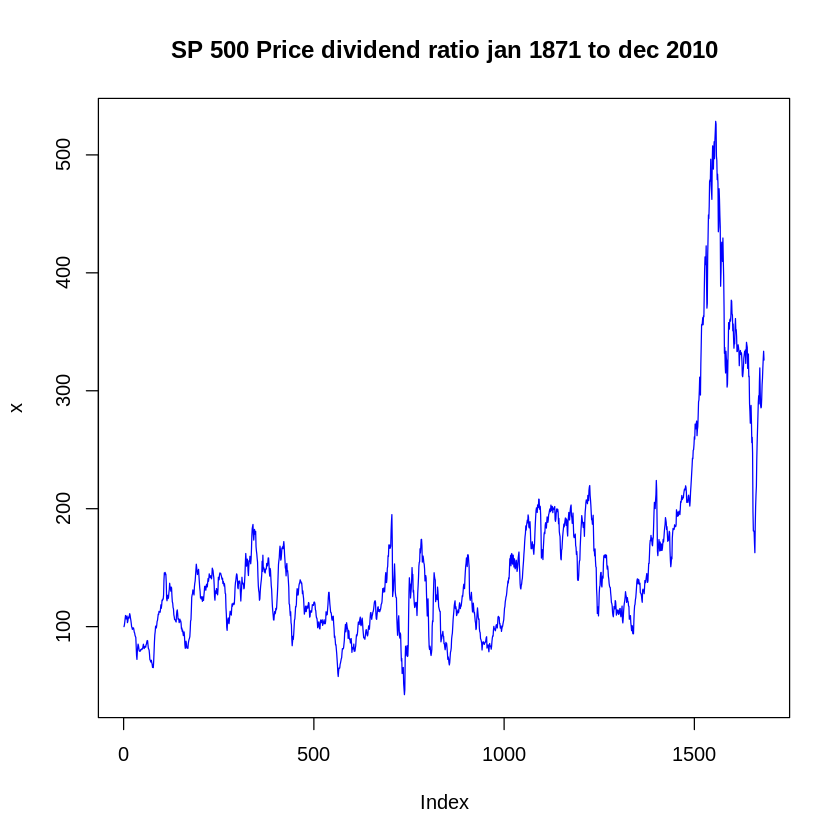

In [47]:
library(MultipleBubbles)

x<-sp_data

plot(x,type='l',col='blue', main = "SP 500 Price dividend ratio jan 1871 to dec 2010")